In [1]:
import warnings

from data_loading import *
from utils import DateIter
from threshold_edge_detection import *
from IPython.display import clear_output

In [2]:
parent_dir = 'A:/Gits/Ionosphere/raw_data/multisource_data_NA_20m_T0_24hr/'

full_xarr = create_xarr(
    parent_dir=parent_dir,
    expected_shape=(720, 300),
    dtype=(np.uint16, np.float32),
    apply_fn=mad,
    plot=False,
)

label_df = create_label_df(
    csv_path='../ionospheric_disturbance_segmentation/labels/official_labels.csv'
)

In [3]:
data_out_path = 'processed_data/full_data.joblib'
label_out_path = 'labels/labels.joblib'

print(full_xarr.indexes['date'], label_df.index)
joblib.dump(full_xarr, data_out_path)
joblib.dump(label_df, label_out_path)

# %pip install netCDF4
# full_xarr.to_netcdf('full_data.nc')

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='date', length=2642, freq=None) DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=1460, freq=None)


['labels/labels.joblib']

In [4]:
data_out_path = 'processed_data/full_data.joblib'
label_out_path = 'labels/labels.joblib'

date_iter = DateIter(data_out_path) #, label_df=label_out_path)

In [5]:
def save_wrap(save_dir, fmt='%Y-%m-%d', ext='.png', **kwargs):
    os.makedirs(save_dir, exist_ok=True)
    def wrapped(date):
        date_str = pd.to_datetime(date).strftime(fmt)
        file_path = os.path.join(save_dir, date_str + ext)
        plt.savefig(file_path, **kwargs)
        return
    return wrapped

In [36]:
def run_edge_detect(
    dates,
    x_trim=1/12,
    y_trim=.08,
    sigma=4.2, # 3.8 was good
    qs=[.4, .5, .6],
    occurence_n = 60,
    i_max=30,
    plot=True,
    clear_every=100,
    plt_save_path=None,
    csv_save_path=None,
    display_head=None,
):
    sums, processed_dates = list(), list()
    if plt_save_path is not None:
        save_plt = save_wrap(plt_save_path)
    else:
        save_plt = None
        
    final_edge_dict = dict()
    
    if dates == 'all':
        date_gen = date_iter.iter_all()
    else:
#         try:
        date_gen = date_iter.iter_dates(dates, raise_missing=False)
#         except KeyError as ke:
#             missing_dates = 
            
    
    print(next(date_gen))
    for i, (date, arr) in enumerate(date_gen): #('2018-01-01','2017-01-30'))):
        if arr is None:
            warnings.warn(f'Date {date} has no input')
            continue
            
        if not i % clear_every:
            clear_output()

        xl_trim, xr_trim = x_trim if isinstance(x_trim, (tuple, list)) else (x_trim, x_trim)
        yl_trim, yr_trim = x_trim if isinstance(y_trim, (tuple, list)) else (y_trim, y_trim)
        xr, xl = math.floor(xl_trim * arr.shape[0]), math.floor(xr_trim * arr.shape[0])
        yr, yl = math.floor(yl_trim * arr.shape[1]), math.floor(yr_trim * arr.shape[1])

        arr = arr[xr:-xl, yr:-yl]
#         display(
#             arr.coords,
#             arr.dims,
#         )
#         assert False
        heights = arr.coords['height']
        times = arr.coords['time'].to_pandas().dt.strftime('%H:%M')
        
        arr = np.nan_to_num(arr, nan=0)

        arr = gaussian_filter(arr.T[::-1,:], sigma=(sigma, sigma)) 
        med_lines, min_line, minz_line = measure_thresholds(
            arr[::-1,:], 
            qs=qs, 
            occurrence_n=occurence_n, 
            i_max=i_max
        )

        data = pd.DataFrame(np.array(med_lines).T, index=times, columns=qs).reset_index(names='Time')
        min_line = pd.DataFrame(min_line, index=times, columns=['Height']).reset_index(names='Time')
#         data_uncertainty = data.rolling(32).corr().groupby(level=0).apply(non_diag_corr)

        final_edge_dict[date] = minz_line

        if plot or save_plt is not None:
            fig, ax = plt.subplots(1, 1, figsize=(15,8))
            plt.title(f'| {date} |')
#             ax.axis('off')
            sns.heatmap(
                pd.DataFrame(arr[::-1], index=heights, columns=times), 
                robust=True, 
                cbar=False, 
                ax=ax,
            )
            ax.invert_yaxis()

            sns.lineplot(data=data, alpha=.75, dashes=False, ax=ax, palette='light:b')
            sns.lineplot(data=min_line, x='Time', y='Height', color='grey', alpha=1, dashes=False, ax=ax)

            if save_plt is not None:
                save_plt(date)
            
#             sums.append(round(s, 0))
            processed_dates.append(date)
            
            if plot:
                plt.show()
            else:
                plt.clear()
                
    ################ Special Request, should be removed ######################################################
#     pd.Series(sums, index=dates, name='Total Counts').to_frame().to_csv('./January2020Edges/total_counts.csv')
    ##########################################################################################################
    
    final_edge_df = pd.DataFrame(final_edge_dict)
    if csv_save_path:
        final_edge_df.to_csv(csv_save_path)
    
    if display_head:
        display(final_edge_df.head(display_head))
    
    return final_edge_df

(600, 2) (600,)


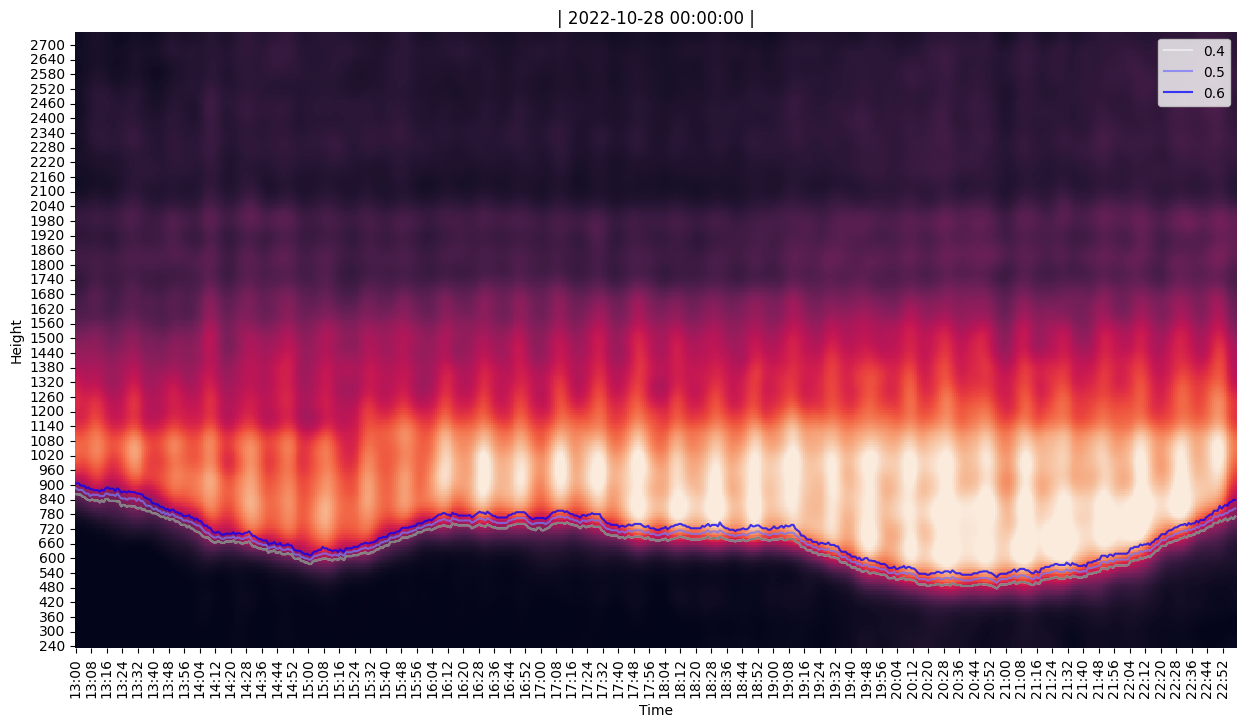

(600, 2) (600,)


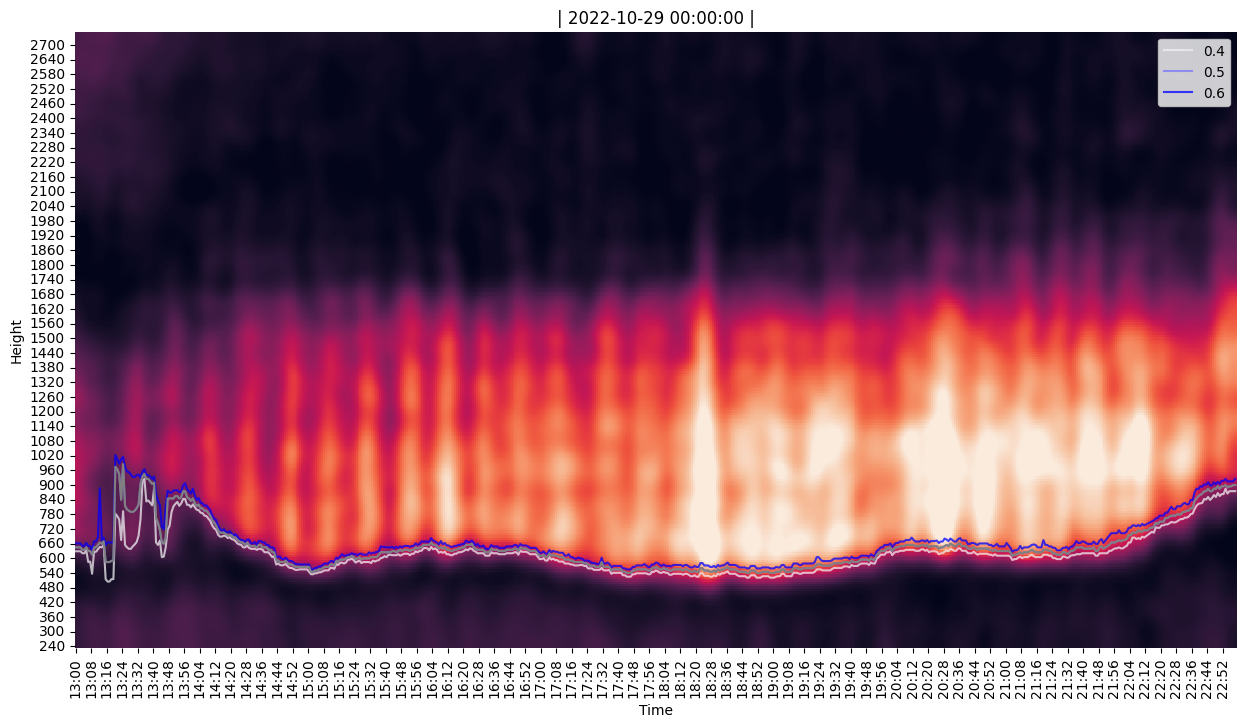

(600, 2) (600,)


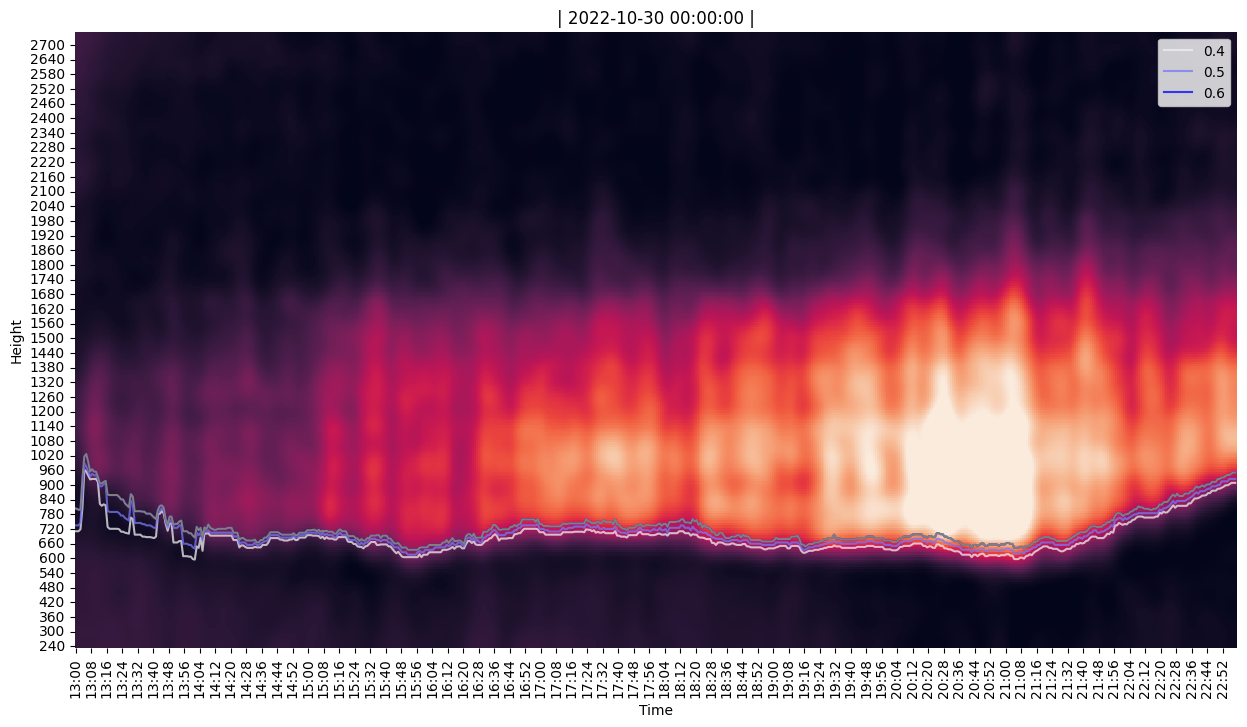

C:\Users\Nick\AppData\Local\Temp\ipykernel_13028\2561692418.py:35: UserWarning: Date 2022-10-31 00:00:00 has no input
  warnings.warn(f'Date {date} has no input')


,2022-10-28,2022-10-29,2022-10-30
0,63.093714,41.186736,53.509749
1,62.790133,40.994732,57.280352
2,62.473748,40.798412,60.896055
3,62.148798,40.602914,64.260457
4,61.818782,40.405196,67.279943


In [38]:
run_edge_detect(
    [('2022-10-27','2022-10-31')], 
    csv_save_path=None,
    plot=True,
    plt_save_path='A:/Gits/Ionosphere/ionospheric_edge_detection/outputs/October2022Edges'
).head()

In [ ]:
today = pd.to_datetime('today').strftime('%Y-%m-%d')
full_edge_path = f'processed_data/final_edges_{today}_run.csv'

final_edge_df = run_edge_detect(
    'all',
    qs=[.4],
    clear_every=10,
    csv_save_path=full_edge_path,
    plot=False,
)
final_edge_df

In [ ]:
def plot_date(date_iter, edge_df, date, side_trim=.08):
    if isinstance(edge_df, str):
        edge_df = pd.read_csv(edge_df, index_col=0)
        edge_df.columns = pd.to_datetime(edge_df.columns)
    
    date = pd.to_datetime(date)
    arr = date_iter.get_date(date)
    x_trim = math.floor(side_trim * arr.shape[0])
    y_trim = math.floor(side_trim * arr.shape[1])
    arr = arr[x_trim:-x_trim, y_trim:-y_trim]
    
    edge = edge_df[date]
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    plt.title(date)
    ax.axis('off')
    sns.heatmap(arr.T, robust=True, cbar=False, ax=ax)
    ax.invert_yaxis()

    sns.lineplot(data=edge, color='white', alpha=1, dashes=False, ax=ax)    
    plt.show()
    return

plot_date(date_iter, final_edge_df, '2020-01-20', side_trim=side_trim)